# Optical simulation with FEMWELL

In this notebook we will go over how to handle the optical simulation part in the imodulator workflow by using `FEMWELL`. Our goal is to explore how to get the data from the `PhotonicDevice` to the optical simulator and how to inspect the data properly.

<div style="text-align: center;">
  <img src="support/main.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

To illustrate how to do this, we will use the class developed in `Building a Photonic Device` tutorial: `InP_EOPM`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel
from imodulator.OpticalSimulator import OpticalSimulatorFEMWELL

%matplotlib inline

def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
        eps_rf_metal = np.asarray([freq, eps_rf_metal])
        
        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        bcb_eps = np.asarray([freq, bcb_eps])
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )

        self.sig_metal = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
                self.w_sig_metal/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )

    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )

Successfully imported lumapi


In [2]:
eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

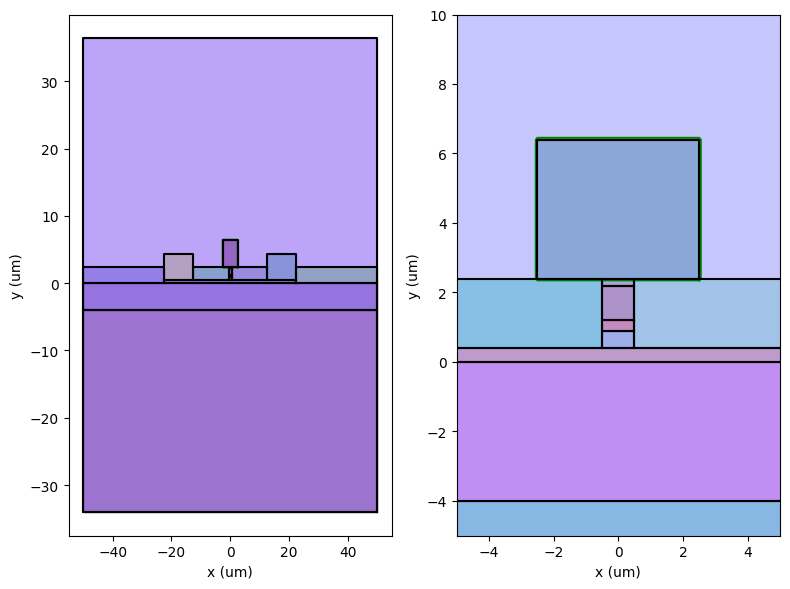

In [3]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

Now we initialize the optical simulator.

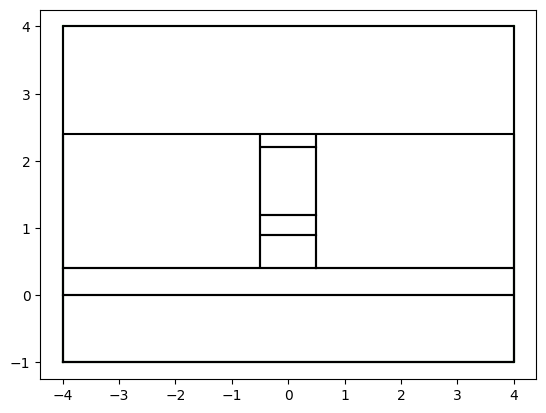

In [14]:
mode = OpticalSimulatorFEMWELL(
    device=eopm.device,
    simulation_window=shapely.box(-4,-1,4,4),
    include_metals=False
)

mode.plot_polygons()


We can generate the mesh and inspect it:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

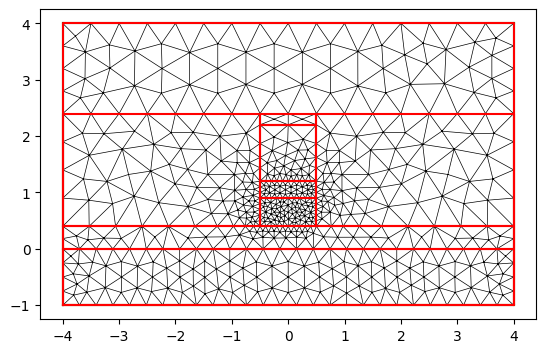

In [15]:
mode.make_mesh()

mode.plot_mesh()

We can also inspect the optical permitivity:

(<Figure size 800x400 with 4 Axes>,
 [<Axes: title={'center': '$\\epsilon_{xx}$ real part'}, xlabel='x (um)', ylabel='y (um)'>,
  <Axes: title={'center': '$\\epsilon_{xx}$ imaginary part'}, xlabel='x (um)', ylabel='y (um)'>])

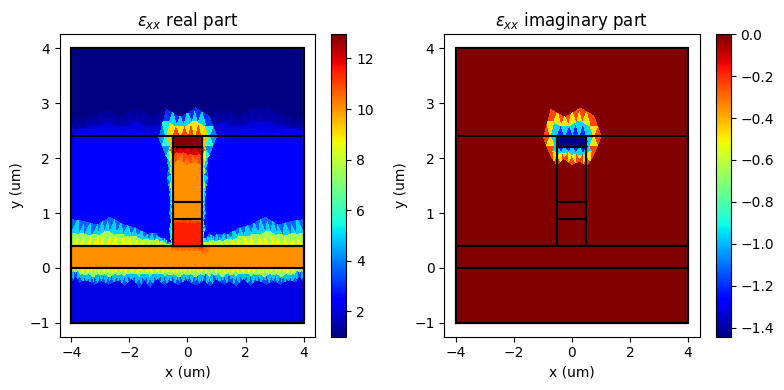

In [16]:
mode.plot_epsilon_optical()

It is important here to recognize that you see a clear linear grating around the structure. This is strictly due to the algorithm for plotting. In case you really need to inspect the values of the `epsilon_optical` as it stands in the mesh, you can do the following:

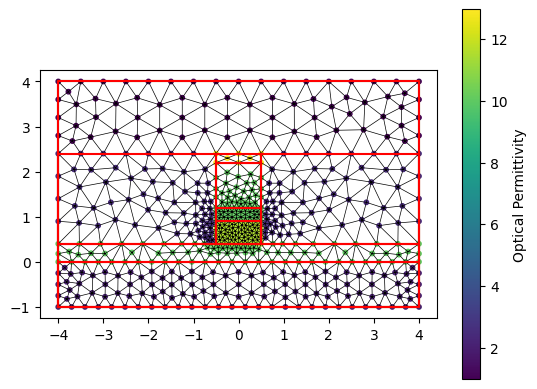

In [17]:
mode.epsilon_optical.shape

# fig = plt.figure()
# ax = fig.add_subplot(111)

mode.plot_mesh(
    plot_polygons=True
)

fig=plt.gcf()
ax=plt.gca()

scat = ax.scatter(
	mode.mesh.p[0],
	mode.mesh.p[1],
	c=mode.epsilon_optical[0,0].real,
	cmap='viridis',
	s=10
)

cbar = plt.colorbar(scat,label='Optical Permittivity')



We can now calculate the modes:

Effective index - mode 0: 3.2990
loss - mode 0: 59462.25 dB/cm
#------------------------------------------#
Effective index - mode 1: 3.2494
loss - mode 1: 49129.62 dB/cm
#------------------------------------------#
Effective index - mode 2: 3.2201
loss - mode 2: 8.15 dB/cm
#------------------------------------------#
Effective index - mode 3: 3.2179
loss - mode 3: 4.05 dB/cm
#------------------------------------------#
Effective index - mode 4: 3.0602
loss - mode 4: 2339.77 dB/cm
#------------------------------------------#


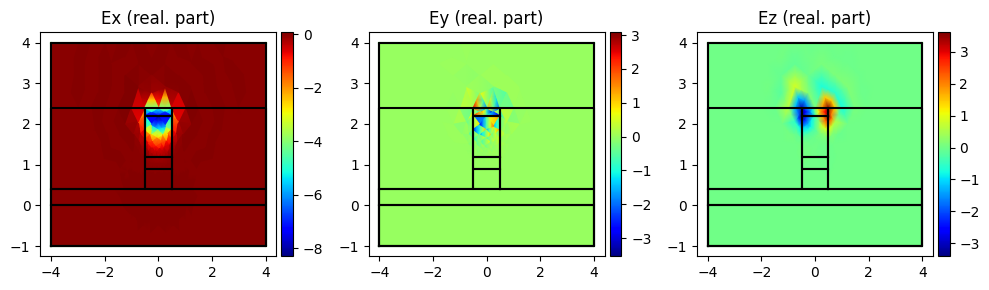

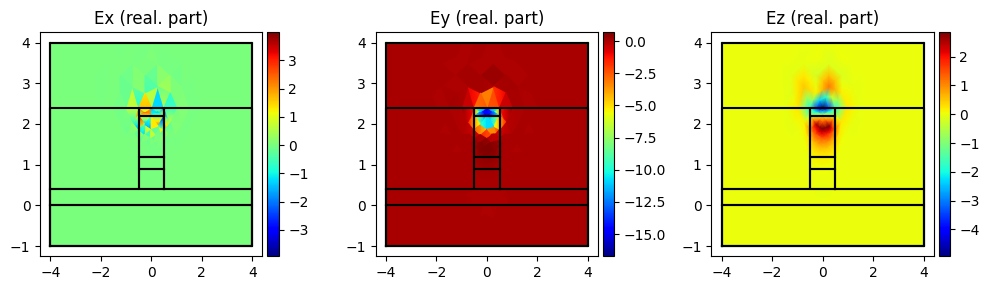

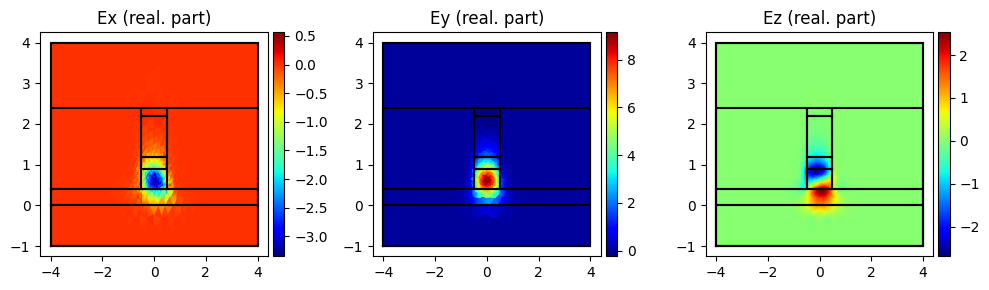

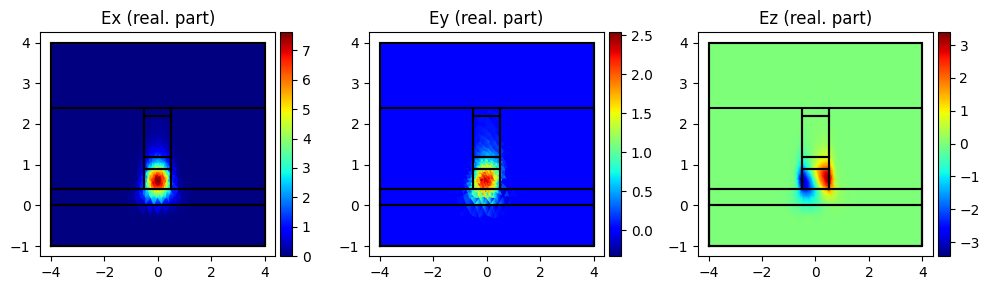

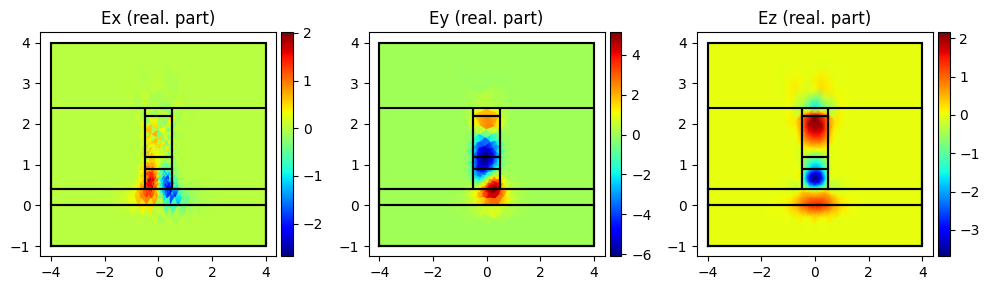

In [18]:
modes = mode.compute_modes(
    wavelength=1.55,
    num_modes=5,
    order=1,
    metallic_boundaries=False,
    n_guess=3.5,
    return_modes=True
)

for i in range(len(modes)):
    print(f'Effective index - mode {i}: {modes[i].n_eff.real:.4f}')
    print(f'loss - mode {i}: {modes[i].calculate_propagation_loss(1e4):.2f} dB/cm')
    print('#------------------------------------------#')

for i in range(len(modes)):
    mode.plot_mode(
        mode=modes[i],
    )

Now it is time to transfer the modes to the `PhotonicDevice`. The way we do it is to simply state what is the TE and TM mode indices. However, it may happen that you are studying some system that there is no TE and TM mode, but rather you are interested in some hybrid modes. This TE and TM are nothing more than labels for the `Imodulator`. No math is done on the assumption that a mode is TE or TM. We take the full vector of any mode you give it. This can be useful if you are exploring some polarization controller for example.

In [19]:
mode.transfer_results_to_device(
	TE_TM_idx=[3,2]
)

c:\Users\20230622\AppData\Local\anaconda3\envs\imodulator_venv\lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


The modes have been transferred to the `PhotonicDevice` and they are stored as an interpolator:

Text(0.5, 0, 'x (um)')

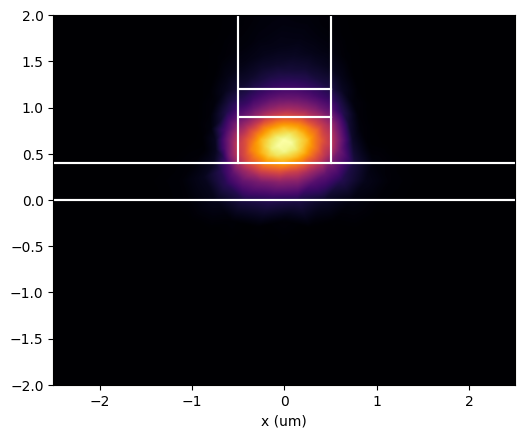

In [20]:
x = np.linspace(-2.5,2.5,1000)
y = np.linspace(-2,2,1000)

xx,yy = np.meshgrid(x,y)

e_field_TE_x = eopm.device.mode['TE']['Ex'](xx,yy)
e_field_TE_y = eopm.device.mode['TE']['Ey'](xx,yy)
e_field_TE_z = eopm.device.mode['TE']['Ez'](xx,yy)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(np.sqrt(np.abs(e_field_TE_x)**2+np.abs(e_field_TE_y)**2+np.abs(e_field_TE_z)**2),
          extent=[x.min(), x.max(), y.min(), y.max()],
          cmap='inferno',
            origin='lower'
)

eopm.device.plot_polygons(
	color_polygon = 'white',
	fig = fig,
    ax = ax,
)

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_xlabel('x (um)')

## Mesh refinement

We can also do some mesh refinement on the mode solver, in case you are interested in very accurate results. 

For details on the mesh refinement, we suggest you look into the tutorials implemented in `FEMWELL`. All we've done here was to reuse their tools to fit our needs.

In [27]:
neff = []
loss = []
nelements = []

mode.make_mesh()
for i in range(30):
    print(f'--- Refinement iteration {i} ---')

    mode.compute_modes(
        wavelength=1.55,
        num_modes=3,
        order=1,
        metallic_boundaries=False,
        n_guess=3.5,
        return_modes=True
    )

    loss_tmp = []
    for opt_mode in mode.modes:
        loss_tmp.append(opt_mode.calculate_propagation_loss(1e4))

    idx_mode = np.argmin(np.abs(loss_tmp))
    # print('Selected mode index for refinement:', idx_mode)
    # print('Loss of se:', loss_tmp)

    nelements.append(mode.mesh.nelements)
    neff.append(mode.modes[idx_mode].n_eff.real)
    loss.append(mode.modes[idx_mode].calculate_propagation_loss(1e4))

    mode.refine_mesh(mode_for_refinement=mode.modes[idx_mode])


# plt.show()

--- Refinement iteration 0 ---


Named boundaries invalidated by a call to Mesh.refined()


--- Refinement iteration 1 ---
--- Refinement iteration 2 ---
--- Refinement iteration 3 ---
--- Refinement iteration 4 ---
--- Refinement iteration 5 ---
--- Refinement iteration 6 ---
--- Refinement iteration 7 ---
--- Refinement iteration 8 ---
--- Refinement iteration 9 ---
--- Refinement iteration 10 ---
--- Refinement iteration 11 ---
--- Refinement iteration 12 ---
--- Refinement iteration 13 ---
--- Refinement iteration 14 ---
--- Refinement iteration 15 ---
--- Refinement iteration 16 ---
--- Refinement iteration 17 ---
--- Refinement iteration 18 ---
--- Refinement iteration 19 ---
--- Refinement iteration 20 ---
--- Refinement iteration 21 ---
--- Refinement iteration 22 ---
--- Refinement iteration 23 ---
--- Refinement iteration 24 ---
--- Refinement iteration 25 ---
--- Refinement iteration 26 ---
--- Refinement iteration 27 ---
--- Refinement iteration 28 ---
--- Refinement iteration 29 ---


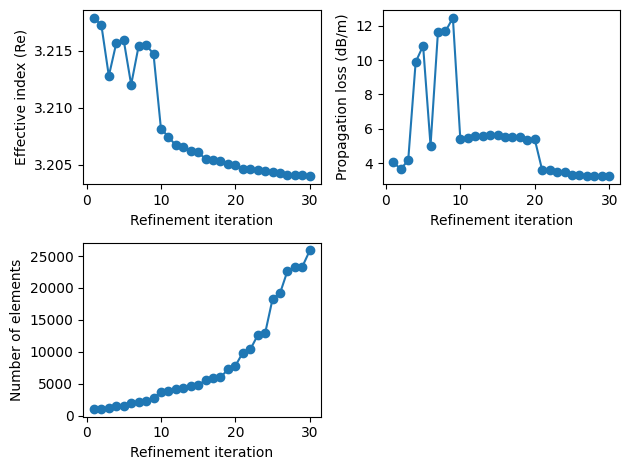

In [28]:
fig = plt.figure()
gs = fig.add_gridspec(2, 2)

n_iterations = np.arange(len(nelements))+1

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])

ax1.plot(n_iterations, neff, marker='o')
ax2.plot(n_iterations, loss, marker='o')
ax3.plot(n_iterations, nelements, marker='o')

ax1.set_xlabel('Refinement iteration')
ax2.set_xlabel('Refinement iteration')
ax3.set_xlabel('Refinement iteration')

ax1.set_ylabel('Effective index (Re)')
ax2.set_ylabel('Propagation loss (dB/m)')
ax3.set_ylabel('Number of elements')

plt.tight_layout()
plt.show()

We can inspect the final mesh

(<Figure size 640x480 with 1 Axes>, <Axes: >)

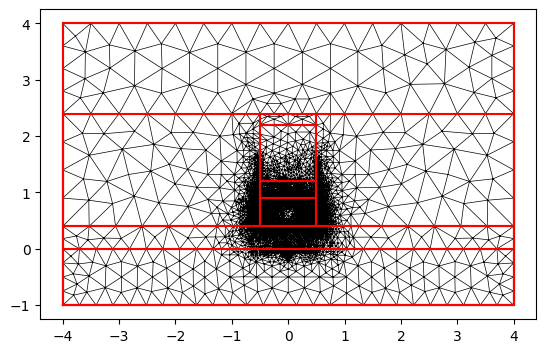

In [29]:
mode.plot_mesh()